Interacting with data: starter code

In [1]:
import copy
import os
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

# Specify path where .pkl files are located
target_dir = "/Users/Emily/Documents/GitHub/quail_volcano/scenarios/conduit1D/"
# Specify path for Quail source code
source_dir = "/Users/Emily/Documents/GitHub/quail_volcano/src/"
# Change to working directory
os.chdir(target_dir)

Call code from notebook (skip block if running from command line)

In [2]:
%%capture
%run "/Users/Emily/Documents/GitHub/quail_volcano/src/quail" "conduit.py"

Import useful packages

In [2]:
# Import quail modules
os.chdir(source_dir)
import argparse
import importlib
import sys

import defaultparams as default_deck
import errors
from general import ShapeType, SolverType, PhysicsType

import meshing.common as mesh_common
import meshing.gmsh as mesh_gmsh
import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp
from multidomain import Domain, Observer

os.chdir(target_dir)

Sample analysis

Text(0, 0.5, 'Energy Density (J/m^3)')

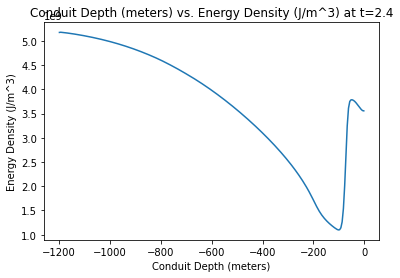

In [7]:
# Load a solver and interact
file_idx = 800
solver = readwritedatafiles.read_data_file(f"conduit1D_{file_idx}.pkl")

# solver.state_coeffs holds the solution values at the nodes of each element
# The shape of state_coeffs is
#   [ne, nb, ns]
# where ne is the number of elements, nb is the number of nodes (also finite
# element basis dimension) in each element, and ns is the number of states
# (ns is currently 7)

# Partial density of air (i.e. mass of air per unit total volume)
pDensityA = solver.state_coeffs[:, :, solver.physics.get_state_index("pDensityA")]
# Partial density of water vapour (exsolved water)
pDensityWv = solver.state_coeffs[:, :, solver.physics.get_state_index("pDensityWv")]
# Partial density of magma (melt + dissolved water + crystals)
pDensityM = solver.state_coeffs[:, :, solver.physics.get_state_index("pDensityM")]
# Momentum per unit volume
x_momentum = solver.state_coeffs[:, :, solver.physics.get_state_index("XMomentum")]
# Total energy (including kinetic) per unit volume
energy_density = solver.state_coeffs[:, :, solver.physics.get_state_index("Energy")]

# The following are advected states that do not participate directly in the
# computation of pressure
# Partial density of total water (exsolved water + dissolved water)
# Note that dissolved water is Wt - Wv
pDensityWt = solver.state_coeffs[:, :, solver.physics.get_state_index("pDensityWt")]
# Partial density of crystals
pDensityC = solver.state_coeffs[:, :, solver.physics.get_state_index("pDensityC")]

# For additional variables:
flag_non_physical = True
p = solver.physics.compute_additional_variable(
  "Pressure", solver.state_coeffs, flag_non_physical)
T = solver.physics.compute_additional_variable(
  "Temperature", solver.state_coeffs, flag_non_physical)
soundspeed = solver.physics.compute_additional_variable(
  "SoundSpeed", solver.state_coeffs, flag_non_physical)
# For more variables, consult
#   physics/multiphasevpT/multiphasevpT.py > MultiphasevpT > AdditionalVariables

# Time
t = solver.time

# To get nodal points (x where each state is evaluated):
# Get reference element nodes
nodal_pts = solver.basis.get_nodes(solver.order)
# Allocate [ne] x [nb, ndims]
x = np.empty((solver.mesh.num_elems,) + nodal_pts.shape)
for elem_ID in range(solver.mesh.num_elems):
  # Fill coordinates in physical space
  x[elem_ID] = mesh_tools.ref_to_phys(solver.mesh, elem_ID, nodal_pts)

# Due to the shape, plotting requires unraveling the states
plt.plot(x.ravel(), energy_density.ravel())
plt.title("Conduit Depth (meters) vs. Energy Density (J/m^3) at t=" + str(round(t, 4)))
plt.xlabel("Conduit Depth (meters)")
plt.ylabel("Energy Density (J/m^3)")
# plt.plot(x.ravel(), pDensityA.ravel())
# In the plot, oscillations at the top of the expansion fan are caused by the
# high order nature of the numerical method. Increasing the artificial viscosity
# suppresses these oscillations somewhat.

<IPython.core.display.Javascript object>


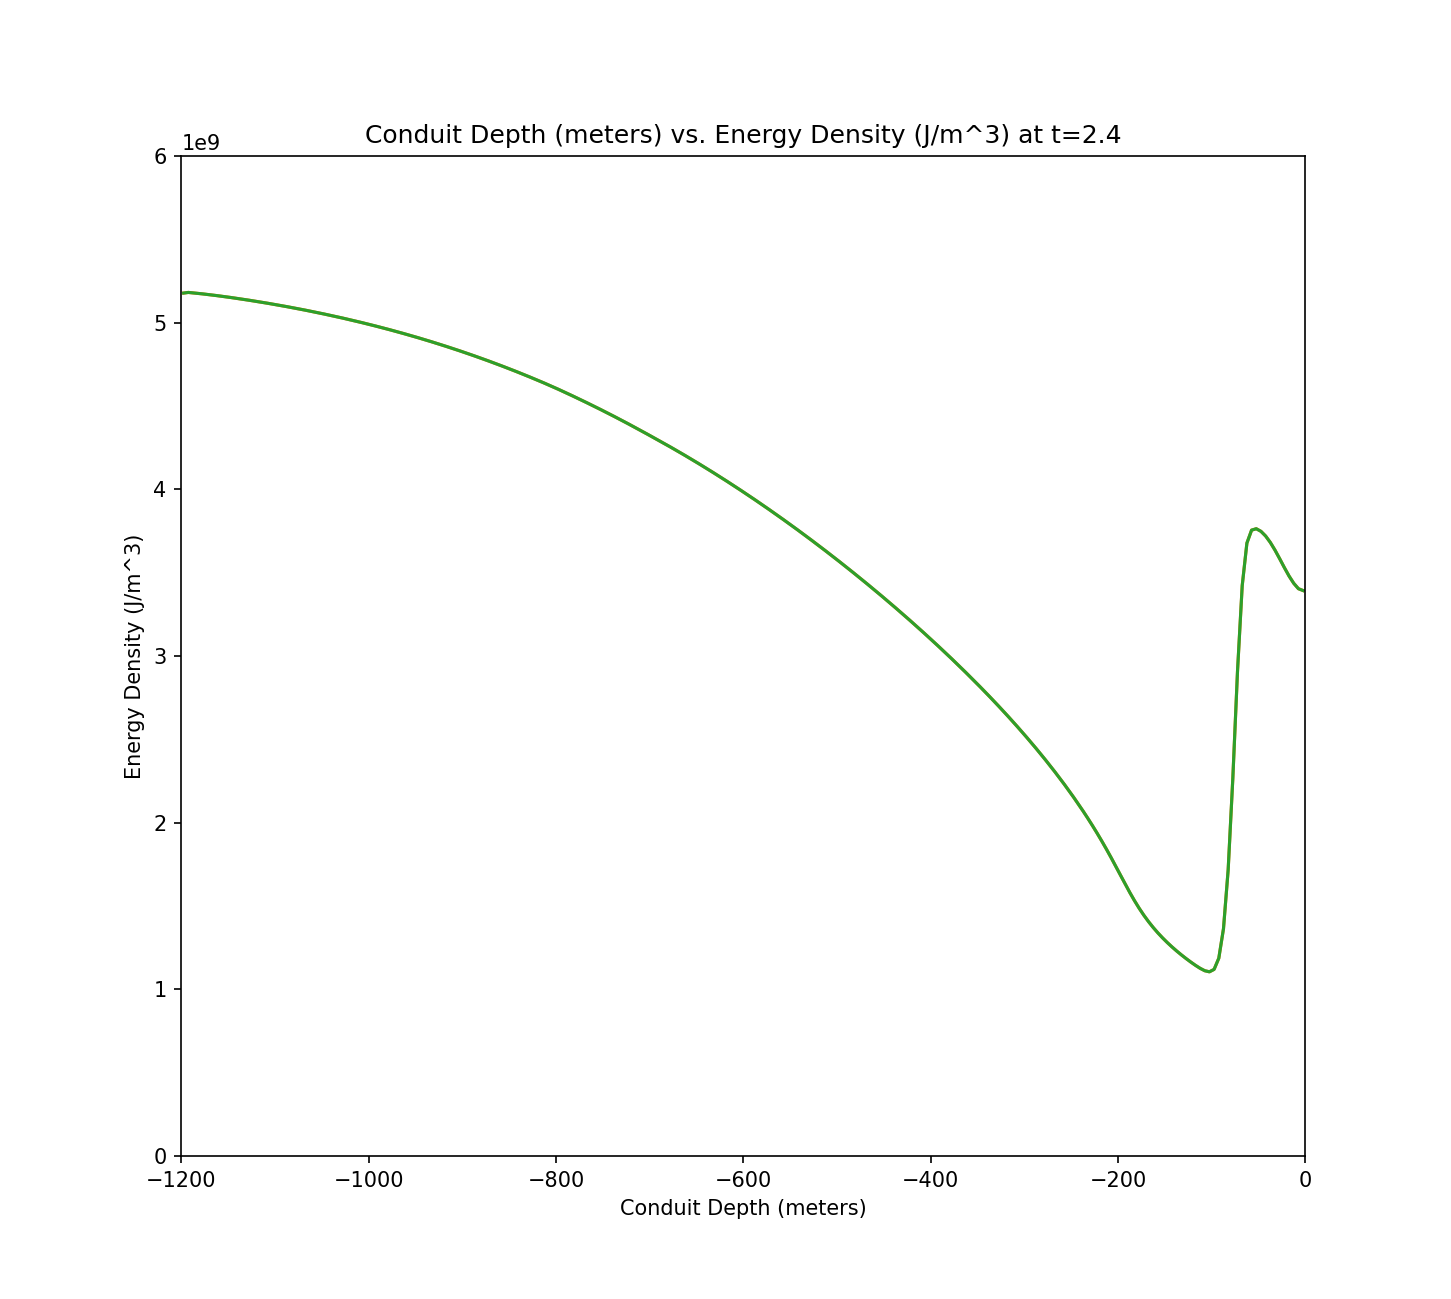

In [44]:
%matplotlib notebook

from matplotlib import animation
from matplotlib.animation import PillowWriter

fig = plt.figure()
ax = plt.axes(xlim=(-1200, 0), ylim=(0, 0.6 * 10 ** 10))
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    solver = readwritedatafiles.read_data_file(f"conduit1D_{i}.pkl")  
    
    
    # all of the options for variables to graph
    pDensityWv = solver.state_coeffs[:, :, solver.physics.get_state_index("pDensityWv")]
    energy_density = solver.state_coeffs[:, :, solver.physics.get_state_index("Energy")]
    p = solver.physics.compute_additional_variable("Pressure", solver.state_coeffs, flag_non_physical)
    T = solver.physics.compute_additional_variable("Temperature", solver.state_coeffs, flag_non_physical)
    
    nodal_pts = solver.basis.get_nodes(solver.order)
        # Allocate [ne] x [nb, ndims]
    x = np.empty((solver.mesh.num_elems,) + nodal_pts.shape)
    for elem_ID in range(solver.mesh.num_elems):
        # Fill coordinates in physical space
        x[elem_ID] = mesh_tools.ref_to_phys(solver.mesh, elem_ID, nodal_pts)
    line.set_data((x.ravel(), T.ravel()))
    return line,

animation = animation.FuncAnimation(fig, animate, init_func=init, frames=834, interval=20, blit=True)

# writer to create and save gif
#writer = PillowWriter(fps=50)
#animation.save('x_vs_energy_ocean.gif',writer=writer)

#animation.save("x_vs_energy.mp4")

plt.show()

In [19]:
# Load a solver and interact
file_idx = 800
solver = readwritedatafiles.read_data_file(f"conduit1D_{file_idx}.pkl")

# solver.state_coeffs holds the solution values at the nodes of each element
# The shape of state_coeffs is
#   [ne, nb, ns]
# where ne is the number of elements, nb is the number of nodes (also finite
# element basis dimension) in each element, and ns is the number of states
# (ns is currently 7)

# Partial density of air (i.e. mass of air per unit total volume)
pDensityA = solver.state_coeffs[:, :, solver.physics.get_state_index("pDensityA")]
# Partial density of water vapour (exsolved water)
pDensityWv = solver.state_coeffs[:, :, solver.physics.get_state_index("pDensityWv")]
# Partial density of magma (melt + dissolved water + crystals)
pDensityM = solver.state_coeffs[:, :, solver.physics.get_state_index("pDensityM")]
# Momentum per unit volume
x_momentum = solver.state_coeffs[:, :, solver.physics.get_state_index("XMomentum")]
# Total energy (including kinetic) per unit volume
energy_density = solver.state_coeffs[:, :, solver.physics.get_state_index("Energy")]

# The following are advected states that do not participate directly in the
# computation of pressure
# Partial density of total water (exsolved water + dissolved water)
# Note that dissolved water is Wt - Wv
pDensityWt = solver.state_coeffs[:, :, solver.physics.get_state_index("pDensityWt")]
# Partial density of crystals
pDensityC = solver.state_coeffs[:, :, solver.physics.get_state_index("pDensityC")]

# For additional variables:
flag_non_physical = True
p = solver.physics.compute_additional_variable(
  "Pressure", solver.state_coeffs, flag_non_physical)
T = solver.physics.compute_additional_variable(
  "Temperature", solver.state_coeffs, flag_non_physical)
soundspeed = solver.physics.compute_additional_variable(
  "SoundSpeed", solver.state_coeffs, flag_non_physical)
# For more variables, consult
#   physics/multiphasevpT/multiphasevpT.py > MultiphasevpT > AdditionalVariables

# Time
t = solver.time

# To get nodal points (x where each state is evaluated):
# Get reference element nodes
nodal_pts = solver.basis.get_nodes(solver.order)
# Allocate [ne] x [nb, ndims]
x = np.empty((solver.mesh.num_elems,) + nodal_pts.shape)
for elem_ID in range(solver.mesh.num_elems):
  # Fill coordinates in physical space
  x[elem_ID] = mesh_tools.ref_to_phys(solver.mesh, elem_ID, nodal_pts)

# Due to the shape, plotting requires unraveling the states
plt.plot(x.ravel(), T.ravel())
plt.title("Conduit Depth (meters) vs. Temperature (Kelvin) at t=" + str(round(t, 4)))
plt.xlabel("Conduit Depth (meters)")
plt.ylabel("Temperature (Kelvin)")
# plt.plot(x.ravel(), pDensityA.ravel())
# In the plot, oscillations at the top of the expansion fan are caused by the
# high order nature of the numerical method. Increasing the artificial viscosity
# suppresses these oscillations somewhat.

Text(44.083333333333336, 0.5, 'Temperature (Kelvin)')